In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd "/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE/"

/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE


In [4]:
import os

In [5]:
root_dir = "/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE/"

root_data_dir = os.path.join(root_dir, "datasets", "BiodivRE")
print(root_data_dir)

dataset = "train"
csv_file_path = "train.csv"

offline_model_file = os.path.join(root_dir, "BiLSTM-BiodivRE-model")
training_history_csv = "training_history.csv"

/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE/datasets/BiodivRE


##Util

In [6]:
def load_model():
    json_file = open(offline_model_file+".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    new_model = model_from_json(loaded_model_json)
    # load weights into new model
    new_model.load_weights(offline_model_file+".h5")
    print("Loaded model from disk")
    return new_model

In [7]:
def save_model(model):
    # serialize model to JSON
    model_json = model.to_json()
    
    with open(offline_model_file+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(offline_model_file+".h5")
    print("Saved model to disk")

In [8]:
def saveDataFrameToCSV(pd1, csv_path, append):  
  dataset_path = os.path.join(root_dir, csv_path)  
  
  if append:
    with open(dataset_path, 'a+') as f:    
      pd1.to_csv(dataset_path,  mode='a', index=False, header=False)    
  else:
    with open(dataset_path, 'a+') as f:    
      pd1.to_csv(dataset_path,  mode='a', index=False, header=True)

##Dataset Preprocessing


In [9]:
import os
import pandas as pd
import numpy as np

In [10]:
def loadData(csv_file_path, header=None, index_col=None):
  dataset_path = os.path.join(root_data_dir, csv_file_path)
  data = pd.read_csv(dataset_path, encoding="latin1", sep=',', header=header, index_col=index_col, names=['Label', 'Sentence'])
  data = data.fillna(method="ffill")
  return data

In [11]:
data_train = loadData(csv_file_path='train.csv', header=None, index_col=None)

In [12]:
data_train.head(10)

,Label,Sentence
0,0,( species : species ) The @QUALITY$ are based ...
1,1,Almost half of the threatened species assessed...
2,0,"In 18 grazed and 21 improved fallows , we esti..."
3,0,BEF research plot where the abundance of @ORGA...
4,0,Indicators : Access to clean fuels and technol...
5,0,We demonstrate that I. noli- tangere and I. te...
6,0,Although its marine biota can be considered re...
7,0,We draw on a spatially-replicated dataset on A...
8,0,Ways to quantify @PHENOMENA$ : rainfall amount...
9,0,"In the light of the @QUALITY$ , it is of major..."


In [13]:
data_test = loadData(csv_file_path='test.csv', header=None, index_col=None)

In [14]:
data_test.head(10)

,Label,Sentence
0,1,( loss_f : average sandloss forest g m-2 -- --...
1,0,"In a grassland biodiversity experiment , we ad..."
2,0,Indicators : Access to clean fuels and technol...
3,1,The cbbL form IA and IC genes associated with ...
4,1,Microbial biomass and diversity increased in m...
5,0,DESCRIPTION Combined @ORGANISM$ Data SUMMARY T...
6,1,"@QUALITY$ ( rare_fg_se ) , dimensionless rare_..."
7,0,Indicators : Access to clean fuels and technol...
8,1,Our results show that existing @ENVIRONMENT$ i...
9,0,Indicators : Access to clean fuels and technol...


In [15]:
data_dev = loadData(csv_file_path='dev.csv', header=None, index_col=None)

In [16]:
data_dev.head(10)

,Label,Sentence
0,1,We hypothesized that ( i ) the food choice of ...
1,0,Ways to quantify precipitation : rainfall amou...
2,0,Potential areas for @PHENOMENA$ almost double ...
3,1,( CSP14 : BEF research plot where the @QUALITY...
4,1,-- - Crown length is calculated as the total t...
5,0,Spatiotemporal modulation of biodiversity in a...
6,0,Ways to quantify precipitation : rainfall amou...
7,0,( Age : the @QUALITY$ class assigned at the ti...
8,1,This system is an important model for understa...
9,0,Ways to quantify @PHENOMENA$ : rainfall amount...


In [17]:
print(len(data_train), len(data_test), len(data_dev))

3200 400 400


###Sentences 

In [18]:
train_texts = data_train[data_train.columns[1]].to_list()
train_labels = data_train[data_train.columns[0]].to_list()

In [19]:
test_texts = data_test[data_test.columns[1]].to_list()
test_labels = data_test[data_test.columns[0]].to_list()

In [20]:
dev_texts = data_dev[data_dev.columns[1]].to_list()
dev_labels = data_dev[data_dev.columns[0]].to_list()

####Exploration

In [21]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

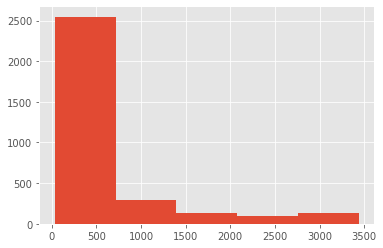

In [22]:
plt.hist([len(s) for s in train_texts], bins=5)
plt.show()

In [23]:
max([len(s) for s in train_texts])

3442

In [24]:
max_len = 128 #selected value outisde the histogram

In [25]:
vocab_txt = []
vocab_txt.extend(train_texts)
print(len(vocab_txt))
vocab_txt.extend(test_texts)
print(len(vocab_txt))
vocab_txt.extend(dev_texts)
print(len(vocab_txt))

3200
3600
4000


In [26]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(vocab_txt)
print("The document count", tokenizer.document_count)
print("The count of words", tokenizer.word_counts)
print("The word index", tokenizer.word_index)

The document count 4000
The count of words OrderedDict([('species', 2508), ('the', 10089), ('quality', 1979), ('are', 439), ('based', 198), ('on', 1072), ('flora', 59), ('of', 7396), ('location', 335), ('china', 284), ('identified', 58), ('by', 4375), ('teng', 46), ('fang', 46), ('and', 5708), ('verified', 46), ('helge', 98), ('bruelheide', 152), ('trees', 706), ('alexandra', 57), ('erfmeier', 64), ('herbs', 44), ('almost', 10), ('half', 44), ('threatened', 19), ('assessed', 23), ('were', 1157), ('considered', 227), ('vulnerable', 19), ('to', 3686), ('impacts', 128), ('phenomena', 1014), ('organism', 1909), ('being', 38), ('most', 111), ('group', 79), ('followed', 30), ('plants', 65), ('reptiles', 7), ('mammals', 12), ('birds', 11), ('in', 4927), ('18', 32), ('grazed', 24), ('21', 19), ('improved', 19), ('fallows', 43), ('we', 457), ('estimated', 112), ('quantified', 26), ('soil', 851), ('organic', 55), ('carbon', 321), ('base', 48), ('cations', 18), ('sand', 140), ('content', 108), ('

In [28]:
n_words = len(tokenizer.word_index.keys())

In [29]:
n_words

4635

In [30]:
len(train_texts)

3200

###X & Y Prep

In [31]:

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def getXYFromSentences(txts, lbls):
  sequences = tokenizer.texts_to_sequences(txts)
  X = pad_sequences(maxlen=max_len, sequences=sequences, padding="post", truncating="post")
  # X = tokenizer.sequences_to_matrix(X)
  y = np.array(lbls)
  # y = np.array([to_categorical(i, num_classes=2) for i in y])
  print(X.shape)
  print(X[0:3])
  print(y.shape)
  print(y[0:3])
  return X, y

In [32]:
X_train, y_train = getXYFromSentences(train_texts, train_labels)

(3200, 128)
[[  14   14    1   23  158  280   62    1  632    2  189  210  643    6
   768  769    3  770    6  471  352  105    3  653  613  788    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [1992  789    2    1 1365   14 1221   53  259 1366    7    1  393    2
    68   25  866    1  436 1366  543 1019    6  608 2413 1829    3 1925
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   

In [33]:
X_dev, y_dev = getXYFromSentences(dev_texts, dev_labels)

(400, 128)
[[ 154 1413  107  340    1  675 1848    2 1071  587  140 2297    6  437
   437  382  222   62    1  410    3  546  444    2  101   14  647  954
   655  708  140  803  949    6   25    4    8  645  558  101   14  276
     4 1055   51 2437  101   14  391    2   17  558 2438 2439    2  101
   103 1274    1  393    2  437  803 2440    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 200    7  198   75   12   63   22   30   97  100   80    6   17   12
    97  100   12   63   22   30    9   80    6    1    9   38   36   12
    27   22   30    9   34   49    6    1    9   38   89   12   27   22
    30    9   34   49    6    1    9   38   36    2    1   87  159   87
   167  172   22   30    9   50    6    

In [34]:
X_test, y_test = getXYFromSentences(test_texts, test_labels)

(400, 128)
[[ 262 1521   36 1497  115  576  271  153   92  944  586   40   10   68
    23   13  226   10  375  262  810    2  627    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   4   17  678   72  135  154 1356   78 1509    6 1292  341 1007    3
   762    8    3  264  368  174    3  119    7  579    2   68    3  655
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    

##Setup the LSTM

In [35]:
from keras import callbacks
from keras.models import Model, Input, model_from_json
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.optimizers import RMSprop

In [36]:
def create_model():
  input = Input(shape=(max_len,))
  #in the line below --> laurance set the input_length = max_len-1 (NLP in TF Week4)
  model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
  model = Dropout(rate=0.1)(model)
  model = Bidirectional(LSTM(units=100, return_sequences=False, recurrent_dropout=0.1))(model)
  model = Dropout(rate=0.25)(model)
  model = Dense(512, activation='relu')(model)  
  model = Dropout(rate=0.25)(model)
  out = Dense(1,  activation='sigmoid')(model)  # segmoid output layer (binary classification)
  
  return Model(input, out)

In [37]:
model = create_model()
#model = load_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [38]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 128, 50)           231750    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 50)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               120800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               102912    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0   

In [39]:
from tensorflow.keras.losses import BinaryCrossentropy

In [40]:
# model.compile(optimizer=RMSprop(),loss=BinaryCrossentropy(reduction='sum_over_batch_size'), metrics=["accuracy"])
# model.compile(optimizer=RMSprop(),loss=BinaryCrossentropy(reduction='none'), metrics=["accuracy"])
model.compile(optimizer=RMSprop(),loss="mse", metrics=["accuracy"])

In [41]:
class myCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.989):
      print("\nReached 98.9% accuracy so cancelling training!")
      self.model.stop_training = True
 

In [42]:
history = model.fit(X_train, y_train, validation_data=(X_dev, y_dev), shuffle=True, batch_size=32, epochs=10, verbose=1, callbacks=[myCallback()])


Train on 3200 samples, validate on 400 samples
Epoch 1/10
3200/3200 [==============================] - 28s 9ms/step - loss: 0.1922 - accuracy: 0.6944 - val_loss: 0.1843 - val_accuracy: 0.7025
Epoch 2/10
3200/3200 [==============================] - 18s 6ms/step - loss: 0.1613 - accuracy: 0.7613 - val_loss: 0.1789 - val_accuracy: 0.7175
Epoch 3/10
3200/3200 [==============================] - 18s 6ms/step - loss: 0.1469 - accuracy: 0.7912 - val_loss: 0.1772 - val_accuracy: 0.7200
Epoch 4/10
3200/3200 [==============================] - 18s 6ms/step - loss: 0.1394 - accuracy: 0.8047 - val_loss: 0.1843 - val_accuracy: 0.7175
Epoch 5/10
3200/3200 [==============================] - 20s 6ms/step - loss: 0.1326 - accuracy: 0.8181 - val_loss: 0.1906 - val_accuracy: 0.7325
Epoch 6/10
3200/3200 [==============================] - 18s 6ms/step - loss: 0.1279 - accuracy: 0.8263 - val_loss: 0.1788 - val_accuracy: 0.7350
Epoch 7/10
3200/3200 [==============================] - 18s 6ms/step - loss: 0.125

In [43]:
save_model(model)

Saved model to disk


In [44]:
hist = pd.DataFrame(history.history)

In [45]:
saveDataFrameToCSV(hist, training_history_csv, append=True)
 

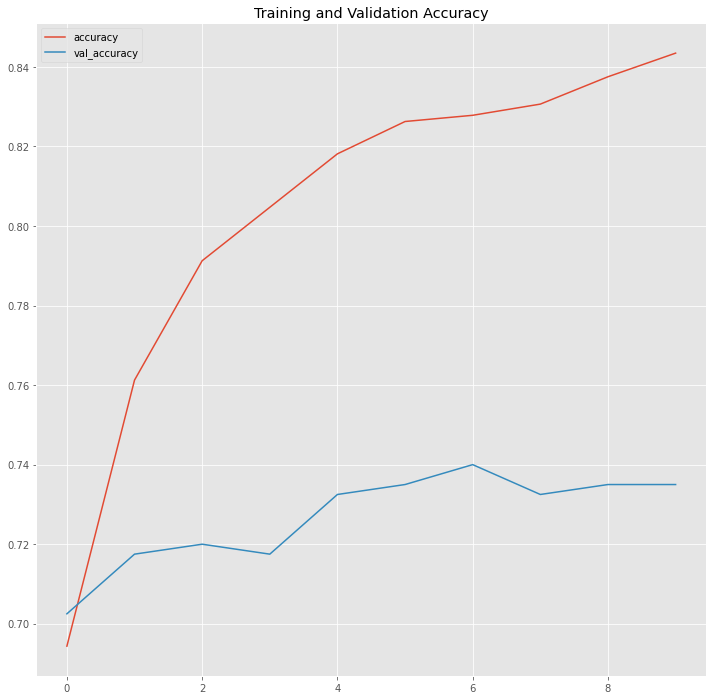

In [46]:
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["val_accuracy"], label="val_accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

##Evaluation

In [47]:
model.evaluate(x=X_test, y=y_test, batch_size=32, verbose=1)

400/400 [==============================] - 1s 3ms/step


[0.18785788476467133, 0.7099999785423279]

In [48]:
test_pred = model.predict(X_test, verbose=1)

400/400 [==============================] - 1s 3ms/step


In [49]:
pred_labels = [ 1 if t >= 0.5 else 0 for t in test_pred]

In [50]:
test_pred[0:10]

array([[0.07258424],
       [0.7821852 ],
       [0.0103775 ],
       [0.20900315],
       [0.79075307],
       [0.07936412],
       [0.9746233 ],
       [0.01065359],
       [0.27406138],
       [0.00819126]], dtype=float32)

In [51]:
pred_labels[0:10]

[0, 1, 0, 0, 1, 0, 1, 0, 0, 0]

###Tailored Evaluation


In [52]:
from classification_metrics import classification_report, replaceMultiple

In [53]:
print(classification_report(test_labels, pred_labels))

                        precision 	 recall 	 f1-score 	 support

                   0	 0.76		 0.79		 0.78		 258	
                   1	 0.60		 0.56		 0.58		 142	


macro avg           	 0.68		 0.68		 0.68		 400	
micro avg           	 0.71		 0.71		 0.71		 400	

